In [1]:
# default_exp datasets_phenom

In [1]:
#export
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_trajectories import segs_inside_fov
from andi_datasets.utils_challenge import label_filter, continuous_label_to_list, extract_ensemble

import inspect
import numpy as np
import pandas as pd
import csv
from tqdm.auto import tqdm

import os
import warnings

In [2]:
import matplotlib.pyplot as plt

# Class constructor

The class is initiated by accessing the `models_phenom` class and inspecting the available models

In [7]:
# export
class datasets_phenom():
    def __init__(self,
                models_class = models_phenom()):
            ''' Constructor of the class '''
            self.models_class = models_class
            self._get_models()
        
    def _get_models(self):        
        '''Loads the available models from the subclass'''

        available_models = inspect.getmembers(self.models_class, inspect.ismethod)      
        available_models = available_models[1:][::-1] # we need this to get rid of the init
        self.avail_models_name = [x[0] for x in available_models]
        self.avail_models_func = [x[1] for x in available_models]
        
    def _get_inputs_models(self, model, get_default_values = False):
        
        model_f = self.avail_models_func[self.avail_models_name.index(model)] 
        defaults = inspect.getfullargspec(model_f).defaults
        params = inspect.getfullargspec(model_f).args[1:]
        if get_default_values:
            return params, defaults
        else:
            return params
        
    def _get_states(self):
        ''' Definition of the possible states found in the ANDI 2022 challenge and their 
        assigned label:
        0: immobile; 1: confined; 2: brownian; 3: anomalous '''
        
        self._states = ['immobile', 'confined', 'brownian', 'anomalous']
        

# `create_dataset`

This function receives a list of dictionaries, each containing the properties of the trajectories to be created. The compulsory input for each dictionary is the key `model`, which defined the phenomenological diffusion model from which to create the trajectories. The rest of the properties are the ones of the model called. If no properties are given, the function automatically choses the default parameters of the model (check `models_phenom` for details).

In [24]:
# export
class datasets_phenom(datasets_phenom):
                
    def create_dataset(self,
                       dics = False,
                       T = None,
                       N_model = None,  
                       path = '',
                       save = False, load = False):
        ''' Given a list of dictionaries, generates trajectories of the demanded properties. 
        This function checks and handles the input dataset and the manages both the creation,
        loading and saving of trajectories.
        Args:
            :dics (list, dictionary, bool):
                - if list or dictionary: the function generates trajectories with the 
                properties stated in each dictionary.
                - if bool: the function generates trajectories with default parameters.
                set for the ANDI2022 challenge for every available diffusion model.
            :T (int or None): 
                - if int: overrides the values of trajectory length in the dictionaries.
                - if None: uses the trajectory length values in the dictionaries.
            :N_model (int or None):
                - if int: overrides the values of number of trajectories in the dictionaries.
                - if None: uses the number of trajectories in the dictionaries
            :save (bool): if True, saves the generated dataset (see self._save_trajectories).
            :load (bool): if True, loads a dataset from path (see self._load_trajectories).
            :path (str): path from where to save or load the dataset.
        '''
        
        self.T = T
        self.N_model = N_model
        self.path = path
        self.dics = dics
        
        '''Managing dictionaries'''
        # If the input is a single dictionary, transform it to list
        if isinstance(self.dics, dict): self.dics = [self.dics]
        # if dics is False, we select trajectories from all models with default values
        if self.dics is False: self.dics = [{'model': model} for model in self.avail_models_name]

                    
        '''Managing folders of the datasets'''  
        self.save = save
        self.load = load
        if self.save or self.load:                
            if self.load:
                self.save = False            
            if not os.path.exists(self.path) and self.load:
                raise FileNotFoundError('The directory from where you want to load the dataset does not exist')                
            if not os.path.exists(self.path) and self.save:
                os.makedirs(self.path) 
                
                
        '''Create trajectories'''
        trajs, labels = self._create_trajectories()
        
        return trajs, labels                        

# `_create_trajectories`, `_save_trajectories`, `_load_trajectories`
Auxiliary functions to `create_trajectories` that allow for creating, load and saving trajectories.

In [21]:
# export
class datasets_phenom(datasets_phenom):   
    
    def _create_trajectories(self):
        ''' Given a list of dictionaries, generates trajectories of the demanded properties.
        First checks in the .csv of each demanded model if a dataset of similar properties
        exists. If it does, it loads it from the corresponding file.
        Return:
            :data_t (array): array containing the generated trajectories
            :data_l (array): array containing the corresponding labels.
        '''

        for dic in self.dics:
            
            dataset_idx, df = self._inspect_dic(dic)
            
            # If the dataset does not yet exists
            if dataset_idx is False:
                # Retrive name and function of diffusion model
                model_f = self.avail_models_func[self.avail_models_name.index(dic['model'])]
                # Create dictionary with only arguments
                dic_args = dict(dic); dic_args.pop('model')
                
                trajs, labels = model_f(**dic_args)
                
                # Save the trajectories if asked
                if self.save:
                    self._save_trajectories(trajs = trajs,
                                            labels = labels,
                                            dic = dic, 
                                            df = df,
                                            dataset_idx = dataset_idx,
                                            path = self.path)                    
            else:
                trajs, labels = self._load_trajectories(model_name = dic['model'],
                                                        dataset_idx = dataset_idx,
                                                        path = self.path)
                
            # Stack dataset
            try:
                data_t = np.hstack((data_t, trajs))                    
                data_l = np.hstack((data_l, labels))
            except:
                data_t = trajs
                data_l = labels
                    
        return data_t, data_l  
    
    def _save_trajectories(self, trajs, labels, dic, df, dataset_idx, path):
        ''' Given a set of trajectories and labels, saves two things:
                - In the .csv corresponding to the demanded model, all the input parameters 
                of the generated dataset.
                - In a .npy file, the trajectories and labels generated.
        '''
        
        file_name = path+dic['model']+'_'+str(df.shape[0])+'.npy'
        
        # Save information in CSV handler
        df = df.append(dic, ignore_index = True)
        df.to_csv(path+dic['model']+'.csv')
        
        # Save trajectories and labels
        data = np.dstack((trajs, labels))
        np.save(file_name, data)
        
    def _load_trajectories(self, model_name, dataset_idx, path):
        ''' Given the path for a dataset, loads the trajectories and labels'''
        
        file_name = path+model_name+'_'+str(dataset_idx)+'.npy'
        data = np.load(file_name)
        return data[:, :, :2], data[:, :  , 2:]
    

In [25]:
dph = datasets_phenom()
path = 'data/'

main =  [{'model': 'dimerization', 'N': 40}
        ]


trajs, labels = dph.create_dataset(T = None, dics = main, N_model = None, path = path, load = False)

# `_inspect_dic`
Given a dictionary, this function checks that it fulfils the constraints of the program and checks the validity of the save/load actions.

In [14]:
# export
class datasets_phenom(datasets_phenom):   

    def _inspect_dic(self, dic):
        '''Checks the information of the input dictionaries, complete missing information with defeault 
        values and then decides about loading/saving depending on parameters.
        '''        
            
        # Add time and number of trajectories information
        if self.N_model is not None:
            dic['N'] = self.N_model
        if self.T is not None:
            dic['T'] = self.T

        # Check if CSV with information of dataset exists. If not, create it
        model_m = dic['model']
        model_f = self.avail_models_func[self.avail_models_name.index(model_m)]    
        # Check arguments and defaults from model's function            
        args = inspect.getfullargspec(model_f).args[1:]
        defaults = inspect.getfullargspec(model_f).defaults
        try:
            df = pd.read_csv(self.path+model_m+'.csv', index_col=0)
        except:                
            # convert to dataframe and add model
            df = pd.DataFrame(columns = args+['model'])                

        # Assign missing keys in dic with default values
        for arg, default in zip(args, defaults):
            if arg not in dic.keys():
                dic[arg] = default

        # Check if updated keys of dic equal keys of csv.
        if set(list(df.keys())) != set(list(dic.keys())):
            raise ValueError('Input model dictionary does not match model´s properties')

        # Check if the dataset already exists:
        df_conditions = df.copy()
        df_conditions = df_conditions.where(pd.notnull(df_conditions), None) # Need in case of empty elements because deafults are None
        for key in dic:
            # We need to transform it to str to do a fair comparison between matrices (e.g. transition matrix, Ds, alphas,...)
            df_conditions = df_conditions.loc[(df_conditions[key].astype(str) == str(dic[key]))]
            if len(df_conditions.index) == 0:
                break

        # If dataset exists
        if len(df_conditions.index) > 0:
            # if the dataset exists and save was True, do not save but load
            if self.save:
                wrn_str = f'The dataset you want to save already exists (file: {model_m}_{df_conditions.index[0]}.npy). Switching to Load mode.'
                warnings.warn(wrn_str)
                dataset_idx = df_conditions.index[0] 
            elif self.load:
                dataset_idx = df_conditions.index[0]
            else:
                dataset_idx = False                 

        # If dataset does no exists
        else:         
            if self.load:
                raise ValueError('The dataset you want to load does not exist.')
            else: # If the dataset does not exist, append empty string.
                # This allows to mix saving and loading
                dataset_idx = False
                
        return dataset_idx, df

# `_get_args`
Given the name of a model, returns its input parameters

In [15]:
# export
class datasets_phenom(datasets_phenom):  
    def _get_args(self, model, return_defaults = False):
        ''' Given the name of a diffusion model, return its inputs arguments.
        Args:
            :model (str): name of the diffusion model (see self.available_models_name)
            :return_defaults (optional, bool): if True, the function will also return
            the default values of each input argument.
        Return:
            :args (list): list of input arguments
            :defaults (optional, list): list of default value for the input arguments.
        '''
        model_f = self.avail_models_func[self.avail_models_name.index(model)]    
        # Check arguments and defaults from model's function            
        args = inspect.getfullargspec(model_f).args[1:]
        defaults = inspect.getfullargspec(model_f).defaults
        if return_defaults:
            return args, defaults
        else:
            return args

# Challenge 2022 Dataset

## Default challenge parameters
This function generates dictionaries of plausible parameters for each experiment. We start with the following groudbase values:


- Fielf of view (fov): $128 x 128 px^2$, with a pixel size of 100 nm, for a size of the box $FOV=12.8 \ \mu m$. We will simulate trajectories in a box of $L = 2*FOV$ and the only considers segments inside the fov. This allows to eliminate problems with boundaries.
- Frame rate $= 0.1 Hz$, i.e. $\Delta t = 100 \ ms  = 0.1 \ s$ .
- Typical $D = 0.01 \ \mu m^2/s$. To calculate the input of the program, we need to consider the following:
    - As a working definition of $D$, valid also for anomalous diffusion, we consider it as proporcional to the variance of the displacements along one dimension at the shortest time lag, i.e. $\sigma_{\Delta x}^2= 2  D \Delta t $
    - Given the values of pixel size and frame rate, in adimensional unit $D$ is given by: $D= 0.01 \ \frac{\mu m^2}{s} \ \frac{0.1 s/ \Delta t }{  0.01 \mu m^2/px^2} = 0.1 px^2/\Delta t $ .
    - Localization precision $\sigma_{x} = 12 \ nm = \frac{12 \ nm} {100 \ nm/px}  = 0.12 \ px$.

In [9]:
#export
class datasets_phenom(datasets_phenom): 
    
    class _df_andi2: 
        'This class is used to define some of the default values set for the ANDI 2022 challenge'
        def __init__(self):        
            # General parameters
            
            self.T = 500                   # Length of simulated trajectories
            self._min_T = 20               # Minimal length of output trajectories
            self.FOV_L = 128               # Length side of the FOV (px)
            self.L = 2*self.FOV_L          # Length of the simulated environment
            'PARTICLES MOVE TOO SLOWLY WITH D = 0.1!!'
            self.D = 1                     # Baseline diffusion coefficient (px^2/frame)
            self.density = 2               # Particle density   
            self.N = self.density*self.L   # Number of particle in the whole experiment
            self.sigma_noise = 0.12        # Variance of the localization noise
            
            self.label_filter = lambda x: label_filter(x, window_size = 5, min_seg = 3) 

### `get_dic_andi2`

In [42]:
#export
class datasets_phenom(datasets_phenom):             
    def _get_dic_andi2(self, model):
        ''' Given the number label of diffusion model, returns a default
        dictionary of the model's parameters to be fed to create_dataset
        The numeration is as follow:
                1: single state
                2: N-state
                3: immobilization
                4: dimerization
                5: confinement
        Args:
            :model (int in [1,6]): number of the diffusion model
        Return:
            :dic (dictionary): dictionary containing the default parameters
            for ANDI2022 of the indicated model.
        '''
        
        dic = {'N': self._df_andi2().N,
               'T': self._df_andi2().T,
               'L': self._df_andi2().L}
        
        # alpha and D for single-state and immobilization
        if model == 1 or model == 3:    
            dic.update({'Ds': [self._df_andi2().D, self._df_andi2().D*0.01], # mean and varianve for D
                        'alphas': np.array([np.random.rand()*(1.5-0.5)+0.5, 0.01])})
            
        # alphas and Ds for 2-state, confinement and dimerization
        if model == 2 or model == 4 or model == 5:            
            
            fast_D = self._df_andi2().D
            slow_D = self._df_andi2().D*np.random.choice([1e-1, 1e-2, 1e-3])           
            
            alpha1 = np.random.rand()*(1.2-0.8)+0.8
            # The second state will be at least 0.2 afar. We make sure not being 
            # outside [0,2]        
            alpha2 = alpha1 + np.random.choice([-1, 1])*(np.random.rand()*(0.6-0.2)+0.2)
            
            dic.update({'Ds': np.array([[fast_D, fast_D*0.01],
                                        [slow_D, slow_D*0.01]]),
                        'alphas': np.array([[alpha1, 0.01],
                                            [alpha2, 0.01]])})
            
        # Particle/trap radius and ninding and unbinding probs for dimerization and immobilization
        if model == 3 or model == 4:
            dic.update({'r': 1,                               # Radius of particles (dimerization) or traps (trapping)
                        'Pu': 0.01,                            # Unbinding probability
                        'Pb': 1})                             # Binding probabilitiy
            
        if model == 1:
            dic.update({'model': self.avail_models_name[0]})
        
        if model == 2:
            dic.update({'model': self.avail_models_name[1],
                        'M': np.array([[0.9, 0.1],            # Transition Matrix
                                       [0.1, 0.9]]),
                        'return_state_num': True              # To get the state numeration back, , hence labels.shape = TxNx4
                       })
        if model == 3:
            dic.update({'model': self.avail_models_name[2],
                        'Nt': self._df_andi2().L})            # Number of traps (density = 1 currently)
        if model == 4:
            dic.update({'model': self.avail_models_name[3],
                        'return_state_num': True              # To get the state numeration back, hence labels.shape = TxNx4
                       })
        
        if model == 5:
            dic.update({'model': self.avail_models_name[4],
                        'r': 10,
                        'Nc': 60,
                        'trans': 0.1})

        return dic

## Generating function
This function generates trajectory datasets like the ones considered in the ANDI 2022 Challenge. It is based in `models_phenom.create_dataset` but also applies:

- Apply Field of View (FOV)
- Add localization noise
- Smooth labels
- Extracts ensemble properties
- Correct labeling of trajectories


**Inputs:**
- Number of experiments (one experiment = one model).

    For each experiment:
    - Number of particles
    - Number of FOVs
    - Parameters of the model
    - Mininum length of trajectories
    
**Outputs:** (this should be the same as the expected challenge inputs)
    
- For each FOV:
    - Ensemble properties (Compulsory: model, $\alpha$ and $D$ distribution)
    - Trajectory properties (list of properties: $\alpha_1$, $D_1$, CP$_1$, $\alpha_2$, $D_2$, CP$_2$,...)

In [44]:
#export
class datasets_phenom(datasets_phenom):
    
    def challenge_2022_dataset(self, 
                              experiments = 5,
                              repeat_exp = True,
                              num_fovs = 20,
                              return_timestep_labs = False,
                              save_data = False,
                              path = 'data/',
                              prefix = ''
                                ):
        ''' 
        Creates a datasets with same structure as ones given in the ANDI 2022 challenge. Default values for the
        various diffusion models have been set such as to be in the same ranges as the ones expected for the
        challenge. For details, check the ANDI 2022 challenge webpage.
        This function will generate as many experiments (associated to one the diffusion models) as demanded.
        For each experiment, as many field of view as wanted can be generated. The default values are taken 
        from datasets_phenom._df_andi2.
        If you want to change the parameters of each model, change them at datasets_phenom._df_andi2 and 
        datasets_phenom._get_dic_andi2. It may be easier to generate the datasets directly from 
        datasets_phenom.create_datasets.        
        
        Args:  
            :experiments (int, list): - if int: Number of experiments to generate. Each experiment is 
                                                generated from one of the available diffusion models.  
                                      - if list: diffusion models to generate
            :repeat_exp (bool, list): (Does not enter into play if experiments is list)
                                      - True: picks at random the diffusion model from the pool
                                      - False: picks the diffusion in an ordered way from the pool
            :num_fovs (int): Number of field of views to get trajectories from in each experiment.
            :return_timestep_labs (bool): if True, the output trajectories dataframes containing also the 
                                          labels alpha, D and state at each time step.
            :save_data (bool): if True, saves all pertinent data.
            :path (str): path where to store the data
            :prefix (str): extra prefix that can be added in front of the files' names.
            
        Return:
            :trajs_out (list): list of lenght (experiments x num_fovs). Each elements are is dataframe
                               containing the trajectories of a particular experiment/fov, in order of 
                               generation (i.e. [exp1_fov1, exp1_fov2, ..., exp2_fov1 ....]).
                               If return_timestep_labs = True, the dataframes also contain the labels
                               at each time step
            :labels_traj_out (list): list of same length of trajs_out containing the labels of the 
                                     corresponding trajectories. Each element contains a list with the 
                                     labels of each trajectory, following the scheme:
                                     [idx_traj, D_1, alpha_1, state_1, CP_1, D_2, alpha_2, .... state_N]
            :labels_ens_out (list): list of same length of trajs_out containing the ensemble labels of 
                                    given experiment. See description of output matrix in 
                                    utils_challenge._extract_ensemble()
            '''
        


        # Set prefixes for saved files
        if save_data:
            pf_labs_traj = path+prefix+'traj_labs'
            pf_labs_ens = path+prefix+'ens_labs'
            pf_trajs = path+prefix+'trajs'

        if return_timestep_labs:
            df_list = []

        # Sets the models of the experiments that will be output by the function
        if isinstance(experiments, int):
            if repeat_exp: # If experiments can be repeated, we just sample randomly
                model_exp = np.random.randint(len(self.avail_models_name), size = experiments)
            else: # If not, we sampled them in an ordered way
                if experiments >= len(self.avail_models_name):
                    num_repeats = (experiments % len(self.avail_models_name))+1
                else:
                    num_repeats = 1
                model_exp = np.tile(np.arange(len(self.avail_models_name)), num_repeats)[:experiments]
            # We add one to get into non-Python numeration
            model_exp += 1
        else:
            model_exp = experiments

        # Output lists
        trajs_out, labels_traj_out, labels_ens_out = [], [], []
        for idx_experiment, model in enumerate(tqdm(model_exp)):

            ''' Generate the trajectories '''
            dic = self._get_dic_andi2(model)
            trajs, labels = self.create_dataset(dics = dic, N_model=50)

            # Add noise the trajectories
            trajs += np.random.randn(*trajs.shape)*self._df_andi2().sigma_noise    

            ''' Apply the FOV '''
            for fov in range(num_fovs):

                # We take as min/max for the fovs a 5 % distance of L
                dist = 0.05
                min_fov = int(dist*self._df_andi2().L)
                max_fov = int((1-dist)*self._df_andi2().L)-self._df_andi2().FOV_L
                # sample the position of the FOV
                fov_origin = (np.random.randint(min_fov, max_fov), np.random.randint(min_fov, max_fov))


                # Checking if file exist and creating an error
                if save_data:
                    if os.path.exists(pf_labs_traj+f'_exp_{idx_experiment}_fov_{fov}.txt') or os.path.exists(pf_labs_ens+f'_exp_{idx_experiment}_fov_{fov}.txt'):
                        raise FileExistsError(f'Target files for experiment {idx_experiment} and FOV {fov}. Delete the file or change path/prefix.')            



                ''' Go over trajectories in FOV (copied from utils_trajectories for efficiency) '''
                trajs_fov, array_labels_fov, list_labels_fov, idx_segs_fov = [], [], [], []
                idx_seg = -1
                for idx, (traj, label) in enumerate(zip(trajs[:, :, :].transpose(1,0,2),
                                                        labels[:, :, :].transpose(1,0,2))):
                    nan_segms = segs_inside_fov(traj, 
                                                fov_origin = fov_origin,
                                                fov_length = self._df_andi2().FOV_L,
                                                cutoff_length = self._df_andi2()._min_T)

                    if nan_segms is not None:
                        for idx_nan in nan_segms:  
                            idx_seg+= 1

                            seg_x = traj[idx_nan[0]:idx_nan[1], 0]
                            seg_y = traj[idx_nan[0]:idx_nan[1], 1]
                            trajs_fov.append(np.vstack((seg_x, seg_y)).transpose())

                            lab_seg = []
                            for idx_lab in range(labels.shape[-1]):
                                lab_seg.append(self._df_andi2().label_filter(label[idx_nan[0]:idx_nan[1], idx_lab]))
                            lab_seg = np.vstack(lab_seg).transpose()                    
                            array_labels_fov.append(lab_seg)

                            # Tranform continuous labels to list for correct output
                            if model == 2 or model == 4: 
                                # if multi-state or dimerization, we get rid of the label of state numbering
                                CP, alphas, Ds, states = continuous_label_to_list(lab_seg[:, :-1])
                            else:
                                CP, alphas, Ds, states = continuous_label_to_list(lab_seg)

                            list_gt = [idx_seg, Ds[0], alphas[0], states[0]]
                            for gtc, gta, gtd, gts in zip(CP, alphas[1:], Ds[1:], states[1:]):
                                list_gt += [gtc, gtd, gta, gts]
                            list_labels_fov.append(list_gt)     

                            if save_data:
                                with open(pf_labs_traj+f'_exp_{idx_experiment}_fov_{fov}.txt', 'a') as f:
                                    writer = csv.writer(f, delimiter=',', lineterminator='\n',)
                                    writer.writerow(list_gt)

                            # Save index of segment with its length to latter append in the dataframe    
                            idx_segs_fov.append(np.ones_like(seg_x)*idx_seg)

                '''Extract ensemble trajectories''' 
                ensemble_fov = extract_ensemble(np.concatenate(array_labels_fov)[:, -1], dic)
                
                df_data = np.hstack((np.expand_dims(np.concatenate(idx_segs_fov), axis=1), np.concatenate(trajs_fov)))
                df_traj = pd.DataFrame(df_data, columns = ['traj_idx', 'x', 'y']) 


                if return_timestep_labs:
                    array_labels_fov = np.concatenate(array_labels_fov)
                    df_traj['alpha'] = array_labels_fov[:, 0]
                    df_traj['D'] = array_labels_fov[:, 1]
                    df_traj['state'] = array_labels_fov[:, 2]

                if save_data:
                    # Trajectories                    
                    df_traj.to_csv(pf_trajs+f'_exp_{idx_experiment}_fov_{fov}.csv', index = False)
                    # Ensemble labels
                    with open(pf_labs_ens+f'_exp_{idx_experiment}_fov_{fov}.txt', 'a') as f:
                        if model == 2: num_states = dic['alphas'].shape[0]
                        elif model == 1: num_states = 1
                        else: num_states = 2
                        model_n = dic['model']
                        f.write(f'model: {model_n}; num_state: {num_states} \n')
                        np.savetxt(f, ensemble_fov, delimiter = ';')


                # Add data to main lists (trajectories and lists with labels)   
                trajs_out.append(df_traj)
                labels_traj_out.append(list_labels_fov)
                labels_ens_out.append(ensemble_fov)

        return trajs_out, labels_traj_out, labels_ens_out

In [47]:
dph = datasets_phenom()
num_experiments, num_fovs = 5, 5
df_list, lab_t, lab_e = dph.challenge_2022_dataset(experiments = num_experiments, num_fovs = num_fovs, return_timestep_labs=True, repeat_exp = False)

  0%|          | 0/5 [00:00<?, ?it/s]

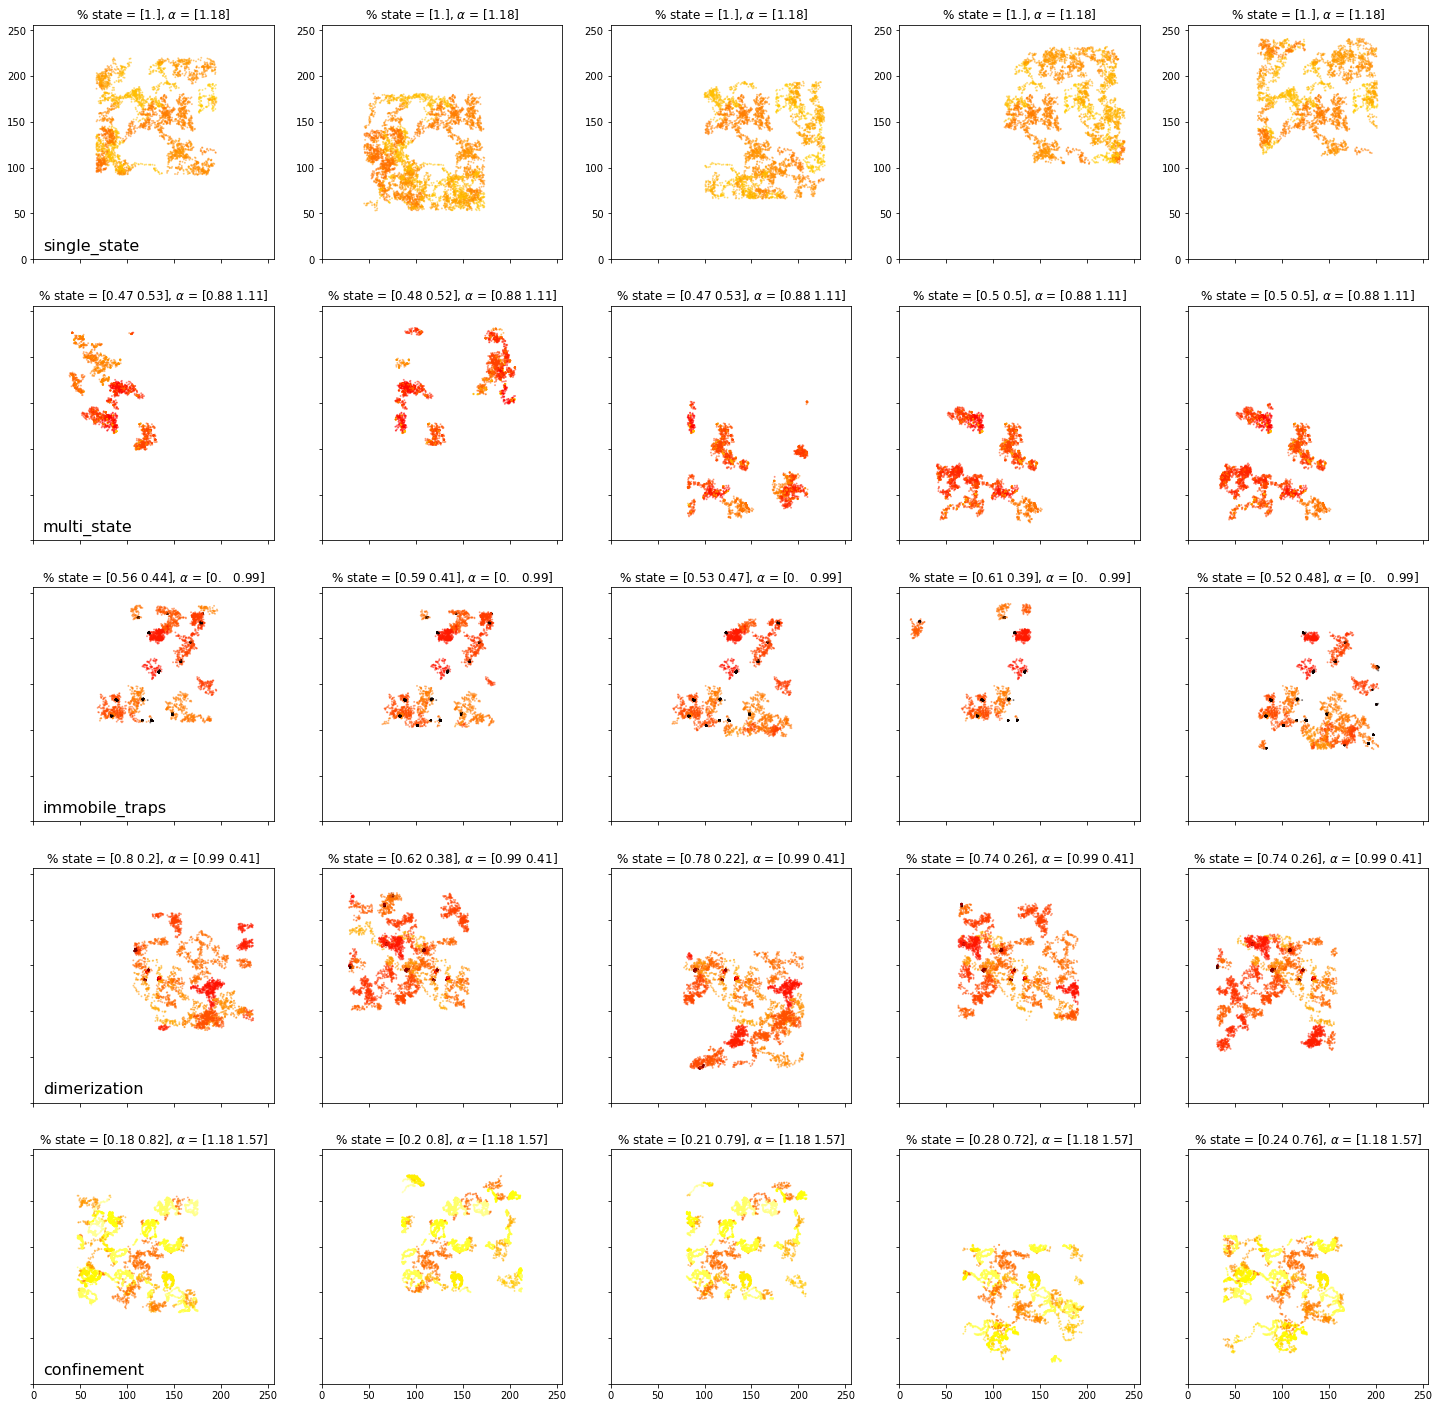

In [66]:
from matplotlib import cm

fig, ax = plt.subplots(num_experiments, num_fovs, figsize = (5*num_fovs, 5*num_experiments))

for idxe, name in zip(range(num_experiments), dph.avail_models_name):
    for idx in range(num_fovs):
        ax[idxe, idx].scatter(df_list[num_fovs*idxe+idx].x.values,
                              df_list[num_fovs*idxe+idx].y.values, 
                              s = 1, alpha = 0.4, 
                              c = cm.hot(df_list[num_fovs*idxe+idx].alpha.values/2))
        
        perc_state = np.round(lab_e[num_fovs*idxe+idx][-1, :]/np.sum(lab_e[num_fovs*idxe+idx][-1, :]), 2)
        ax[idxe, idx].set_title(fr'% state = {perc_state}, $\alpha$ = {np.round(lab_e[num_fovs*idxe+idx][0, :],2)}')
    ax[idxe, 0].text(10, 10, name, fontsize = 16)
plt.setp(ax, xlim = (0, dph._df_andi2().L), ylim = (0, dph._df_andi2().L))
plt.setp(ax[1:, :], yticklabels = '');
plt.setp(ax[:-1, :], xticklabels = '');

#### Densities and physical parameters check

##### Compartments

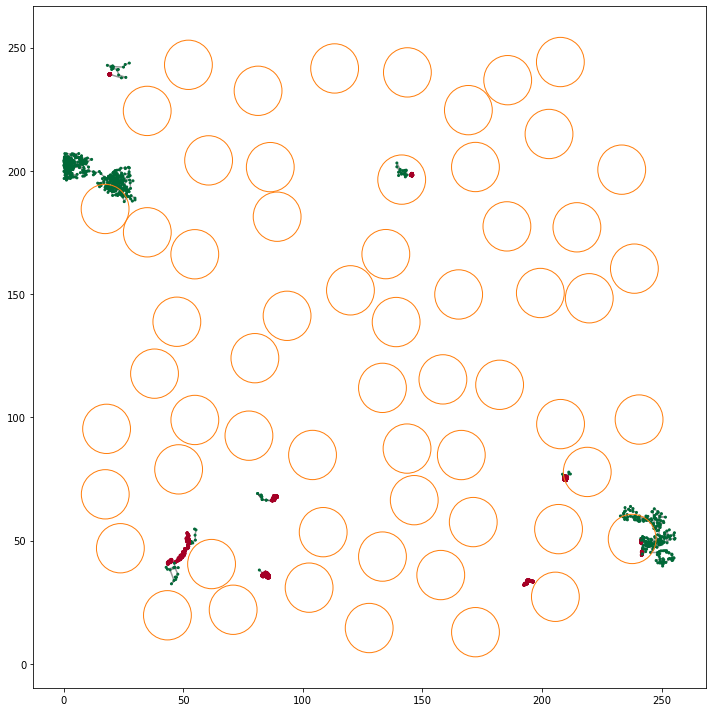

In [135]:
fig, axs = plt.subplots(figsize = (10, 10), tight_layout = True)

dic_comp = dph._get_dic_andi2(5)
r = dic_comp['r']; L = dic_comp['L'] ; Nc = dic_comp['Nc']
comp_center = models_phenom._distribute_circular_compartments(Nc = Nc, r = r, L = L)
trajs, labels = models_phenom().confinement(N = dic_comp['N'], L = L, comp_center = comp_center, r = r, trans = 0.2, Ds = dic_comp['Ds'], alphas = dic_comp['alphas'])


for c in comp_center:
    circle = plt.Circle((c[0], c[1]), r, facecolor = 'None', edgecolor = 'C1', zorder = 10)
    axs.add_patch(circle) 

for _ in range(10): 
    part = np.random.randint(N)    
    axs.plot(trajs[:, part, 0], trajs[:, part, 1], c = 'k', alpha = 0.4, zorder = -2)
    axs.scatter(trajs[:, part, 0], trajs[:, part, 1], c = plt.cm.RdYlGn(labels[:, part, -1]-1), zorder = -1, s = 4, cmap='cividis')   



In [80]:
def plot_rec(ax):
    dist = 0.05
    min_fov = int(dist*dph._df_andi2().L)
    max_fov = int((1-dist)*dph._df_andi2().L)-dph._df_andi2().FOV_L
    # sample the position of the FOV
    fov_origin = (np.random.randint(min_fov, max_fov), np.random.randint(min_fov, max_fov))
    fov_min_x, fov_min_y = fov_origin
    fov_max_x, fov_max_y = np.array(fov_origin)+dph._df_andi2().FOV_L
    currentAxis = ax
    currentAxis.add_patch(Rectangle((fov_min_x, fov_min_y), dph._df_andi2().FOV_L, dph._df_andi2().FOV_L, fill=None, alpha=0.3, lw = 2, label = 'FOV'))

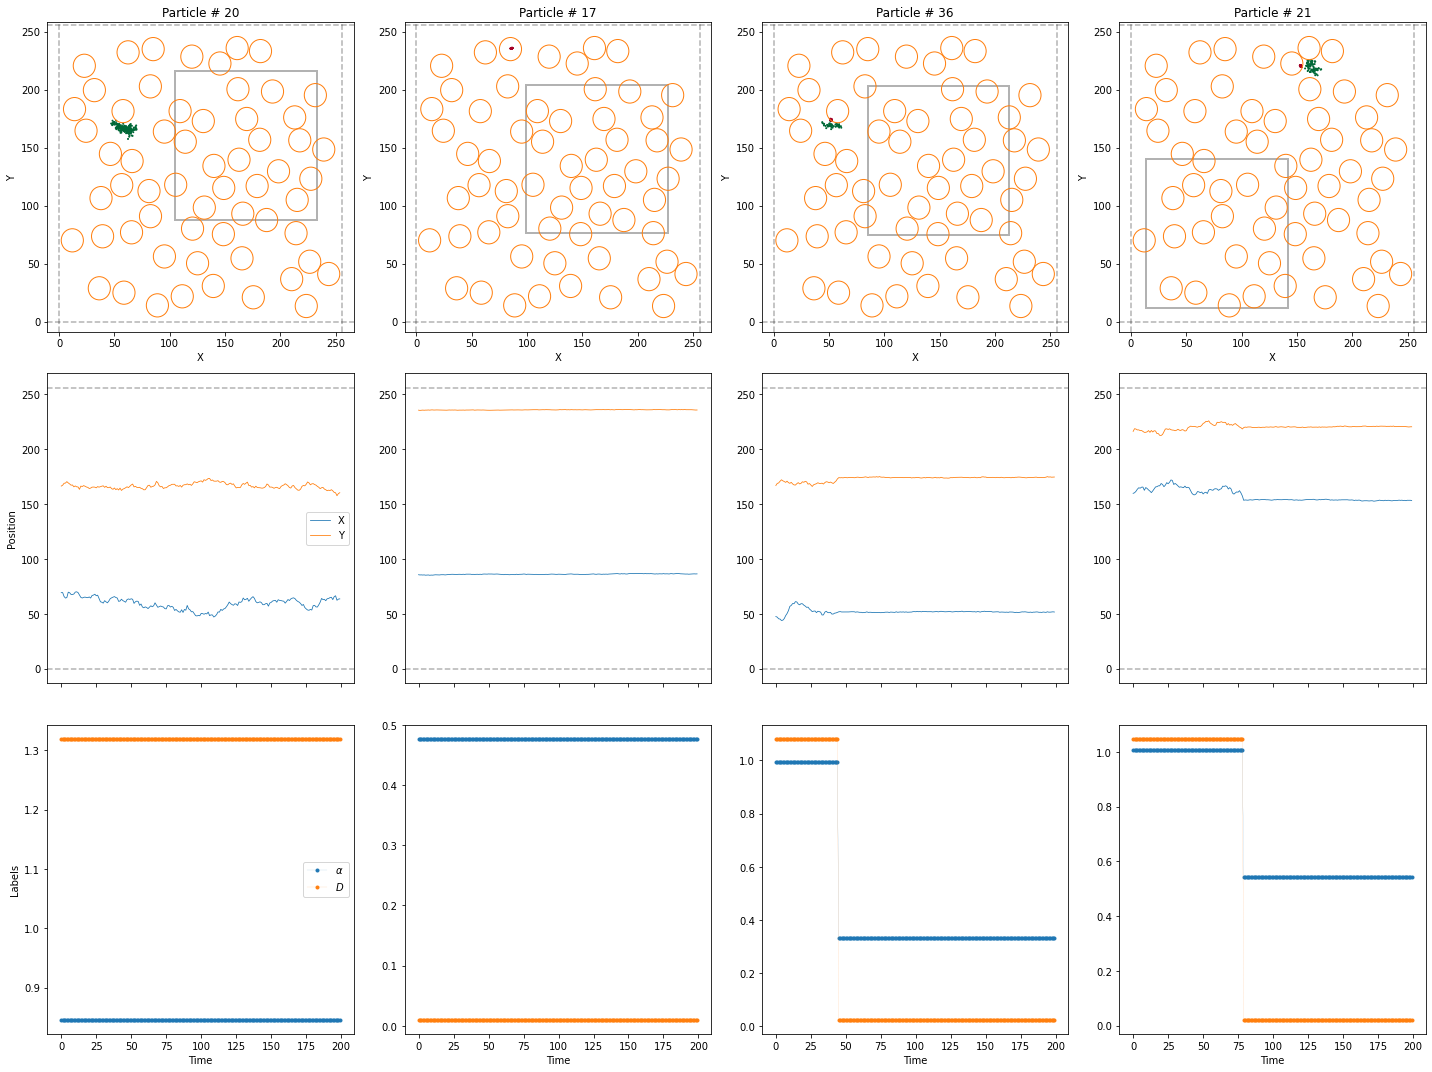

In [127]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(3, 4, figsize = (4*5, 3*5), tight_layout = True)
dic_comp = dph._get_dic_andi2(5)
r = dic_comp['r']; L = dic_comp['L'] ; Nc = dic_comp['Nc']

comp_center = models_phenom._distribute_circular_compartments(Nc = Nc, r = r, L = L)
trajs, labels = models_phenom().confinement(N = N, L = L, comp_center = comp_center, r = r, trans = 0.2, Ds = dic_comp['Ds'], alphas = dic_comp['alphas'])

for ax in axs.transpose():
    
    for c in comp_center:
        circle = plt.Circle((c[0], c[1]), r, facecolor = 'None', edgecolor = 'C1', zorder = 10)
        ax[0].add_patch(circle) 
      
    plot_rec(ax[0])
    
    
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
#     ax[0].plot(trajs[:, part, 0], trajs[:, part, 1])
    ax[0].scatter(trajs[:, part, 0], trajs[:, part, 1], c = cm.RdYlGn(labels[:, part, -1]-1), s = 1)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[:, part, 1], '-', label = 'Y', ms = 3, lw = 0.8)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


    plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

    axs[1, 0].legend()
    plt.setp(axs[1, 0], ylabel = 'Position')
    plt.setp(axs[1, :], xticklabels = '')

    axs[2, 0].legend()
    plt.setp(axs[2, 0], ylabel = 'Labels')
    plt.setp(axs[2, :], xlabel = 'Time');
    

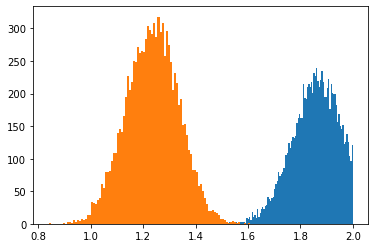

In [115]:
from andi_datasets.utils_trajectories import gaussian
N = 10000
plt.hist(gaussian([np.random.rand()*(1.99-0.5)+0.5, 0.01], size = N, bound = [0, 2]), bins = int(N/100));
plt.hist(gaussian([np.random.rand()*(1.99-0.5)+0.5, 0.01], size = N, bound = [1e-12, 1e6]), bins = int(N/100));

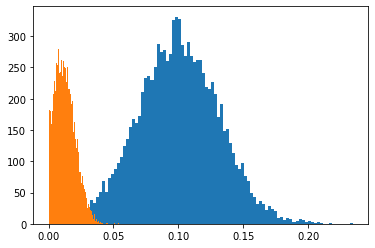

In [95]:
from andi_datasets.utils_trajectories import gaussian
N = 10000
plt.hist(gaussian([0.1, 0.001], size = N, bound = [1e-12, 1e6]), bins = int(N/100));
plt.hist(gaussian([0.01, 0.0001], size = N, bound = [1e-12, 1e6]), bins = int(N/100));

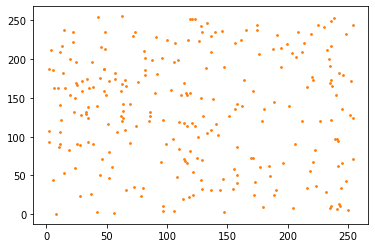

In [78]:
N = a.L*1; r = 1
plt.scatter(np.random.rand(N)*a.L, np.random.rand(N)*a.L, c = 'C1', s = np.pi*r**2)

# Test

In [8]:
# from andi_datasets.datasets_phenom import datasets_phenom


In [13]:
dph = datasets_phenom()
path = 'data/'

main =  [{'model': 'dimerization', 'N': 40},
         {'model': 'immobile_traps', 'N': 53}
        ]


trajs, labels = dph.create_dataset(T = 500, dics = main, N_model = None, path = path, save = True)

ValueError: all input arrays must have the same shape

In [37]:
trajs.shape

(500, 93, 2)

# NBDEV Export

In [133]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
